In [60]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation

from neuralprophet import NeuralProphet, set_log_level

In [116]:
def read_data():
    """ 
    Read data into pandas df
   
    """
    df = pd.read_csv('TRADING_NETWORTH.csv',  engine="python")
    df['DATEE'] = pd.to_datetime(df['DATEE'] , yearfirst=True , format = "%Y%m%d" )
    return df

def read_and_clean_df():
    """
    Convert data to a univariate ts with ds and y col.
    """

    df = read_data()
    df['DATEE'] = pd.to_datetime(df['DATEE'])
    df = df[['DATEE','NETWORTH']]
    df.columns = ['ds','y']

    return df


def plot_data():
    """
    Read clean data and plot. 
    """

    df = read_and_clean_df()
    fig = px.line(df, x='ds', y='y', title='Cristiano Ronaldos Trading Networh', template='plotly_dark')
    fig.show()    



def accuracy(obs, pred):
    """
    Calculate accuracy measures
    :param obs: pd.Series of observed values
    :param pred: pd.Series of forecasted values
    :return: dict with accuracy measures
    """

    obs, pred = np.array(obs.dropna()), np.array(pred.dropna())

    assert len(obs) == len(pred), f'accuracy(): obs len is {len(obs)} but preds len is {len(pred)}'

    rmse = np.sqrt(np.mean((obs - pred)**2))
    mape = np.mean(np.abs((obs - pred) / obs)) 

    return (rmse, mape)

def fit_prophet(df):
    """
    Fit Prophet model and return 
    Source: https://facebook.github.io/prophet/docs/quick_start.html#python-api
    """

    # fit model
    m = Prophet()
    m.fit(df)

    # create forecast
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)

    # create plots
    pred_plot = plot_plotly(m, forecast)
    comp_plot = plot_components_plotly(m, forecast)

    return (m, forecast, pred_plot, comp_plot)


def eval_prophet(m):
    """
    Perform CV on data and evaluate. Note TS CV differs from regular CV.
    IMPORTANT: this is correct eval method according to the docs, but differs from NeuralProphet 
               so I built a custom function.
    """

    df_cv = cross_validation(m, initial='100 days', period='180 days', horizon = '365 days')

    return (df_cv, performance_metrics(df_cv))


def fit_neural(df, params=None):
    """
    FIt NeuralProphet and return key objects.
    """

    # fit 
    m = NeuralProphet(**params) if params is not None else NeuralProphet()
    metrics = m.fit(df, freq="D")

    df_future = m.make_future_dataframe(df, periods=365)
    forecast = m.predict(df_future, raw=True, decompose=False) if params is not None else m.predict(df_future)

    if params is None:
        fig_forecast = m.plot(forecast)
        fig_components = m.plot_components(forecast)
        fig_params = m.plot_parameters()

        return (m, forecast, fig_forecast, fig_components, fig_params) 

    else:
        return (None, forecast, None, None)    



def eval_neural(df):
    """
    Perform cross validation on our model.
    IMPORTANT: this is correct eval method according to the docs, but differs from Prophet 
               so I built a custom function.
    """

    # setup k fold CV
    

    folds = NeuralProphet().crossvalidation_split_df(df, freq="D", k=5, fold_pct=0.20, fold_overlap_pct=0.5)

    # return dfs
    metrics_train = pd.DataFrame()
    metrics_test = pd.DataFrame()

    # CV
    for df_train, df_test in folds:
        m = NeuralProphet()
        train = m.fit(df=df_train, freq="D")
        test = m.test(df=df_test)
        metrics_train = metrics_train.append(train)
        metrics_test = metrics_test.append(test)

    return (metrics_train, metrics_test)        


def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):  # Time Series setps (0-99,100-200,,,,) any steps
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

def cv_run_both_models(df, neural_params):
    """
    Create a CV dataset and run both models and return accuracies. Note that both models
    have their own eval methods, but they differ so I built a custom func that does the 
    same thing. 
    :param df: pd.DataFrame of Prophet-specified format
    :param neural_params: dict of params to be passed to NeuralProphet
    :return: tuple of training accuracies
    """

    

    ###splitting dataset into train and test split
    y = df['y']
    training_size=int(len(y)*0.65)
    test_size=len(y)-training_size
    train_data,test_data=df.iloc[0:training_size,:],df.iloc[training_size:len(y),:]


    rmse_p, mape_p = [], []
    rmse_n, mape_n = [], []
    n_training_days = []

   
    n_training_days.append(len(train_data.index))

    # train Prophet and get accuracy 
    _, forecast, *_ = fit_prophet(train_data)
    rmse, mape = accuracy(test_data['y'], forecast.loc[test_data['y'].index, 'yhat'])
    rmse_p.append(rmse)
    mape_p.append(mape)

    # train NeuralProphet and get accuracy 
    _, forecast, *_ = fit_neural(train_data, neural_params)
    rmse, mape = accuracy(test_data['y'], pd.Series(np.array(forecast.iloc[:, 1:]).flatten()))
    rmse_n.append(rmse)
    mape_n.append(mape)

    return pd.DataFrame(dict(
        n_training_days=n_training_days,
        prophet_RMSE=rmse_p,
        neural_RMSE=rmse_n,
        prophet_MAPE=mape_p,
        neural_MAPE=mape_n
    ))    

In [117]:
# Read data
df = read_and_clean_df()

In [73]:
plot_data()

In [74]:
#Prophet
m1, forecast1, forecast_plot1, component_plot1 = fit_prophet(df)
cv_df, prophet_accuracy_df = eval_prophet(m1)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdi15b27/1go1d3dh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdi15b27/91foksaz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99735', 'data', 'file=/tmp/tmptdi15b27/1go1d3dh.json', 'init=/tmp/tmptdi15b27/91foksaz.json', 'output', 'file=/tmp/tmptdi15b27/prophet_modelub5uieap/prophet_model-20221229140036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:00:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:00:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cuto

  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmptdi15b27/lnc7x4ut.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdi15b27/5gm2p1fk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92215', 'data', 'file=/tmp/tmptdi15b27/lnc7x4ut.json', 'init=/tmp/tmptdi15b27/5gm2p1fk.json', 'output', 'file=/tmp/tmptdi15b27/prophet_model99whlslg/prophet_model-20221229140037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:00:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:00:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdi15b27/nvv022bg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdi15b27/5k8fgg1w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [75]:
forecast_plot1.show()
component_plot1.show()
print(prophet_accuracy_df.describe())

                          horizon           mse           rmse            mae  \
count                         329  3.290000e+02     329.000000     329.000000   
mean            201 days 00:00:00  1.135123e+10   96264.399979   80455.187384   
std    95 days 02:50:25.209861311  9.764969e+09   45724.686623   41241.318286   
min              37 days 00:00:00  5.725732e+08   23928.500894   19599.920421   
25%             119 days 00:00:00  3.263556e+09   57127.539862   43138.319449   
50%             201 days 00:00:00  7.980956e+09   89336.196976   73806.625789   
75%             283 days 00:00:00  1.663860e+10  128990.686928  107330.021597   
max             365 days 00:00:00  3.994850e+10  199871.212198  179353.794363   

             mape       mdape       smape    coverage  
count  329.000000  329.000000  329.000000  329.000000  
mean     0.282303    0.240978    0.307828    0.610880  
std      0.188862    0.146230    0.178573    0.176357  
min      0.064221    0.055257    0.062159    0

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True

Finding best initial lr:   0%|          | 0/222 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: 43it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equa

Finding best initial lr:   0%|          | 0/214 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.265% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.265% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.001281320583075285    │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.707% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.707% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True

Finding best initial lr:   0%|          | 0/216 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.265% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.265% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.0013125570258125663   │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.756% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.756% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True

Finding best initial lr:   0%|          | 0/217 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.265% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.265% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.003948647528886795    │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.79% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.79% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True t

Finding best initial lr:   0%|          | 0/219 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.265% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.265% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.0010199309326708317   │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True

Finding best initial lr:   0%|          | 0/220 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.265% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.265% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.006681889295578003    │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

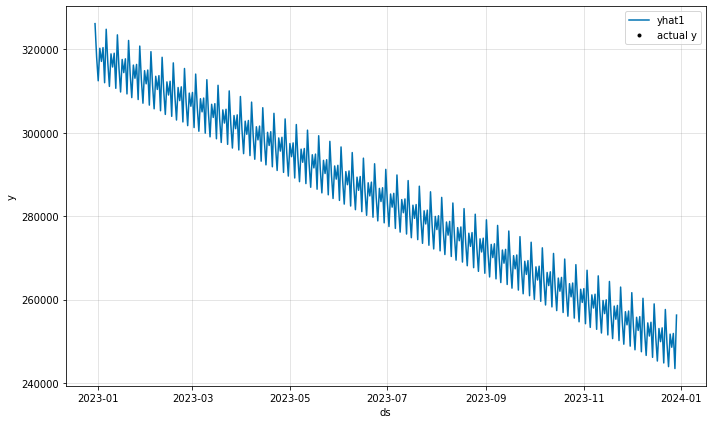

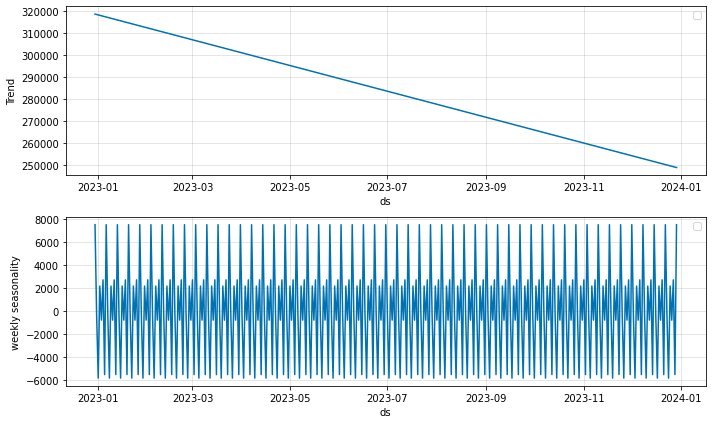

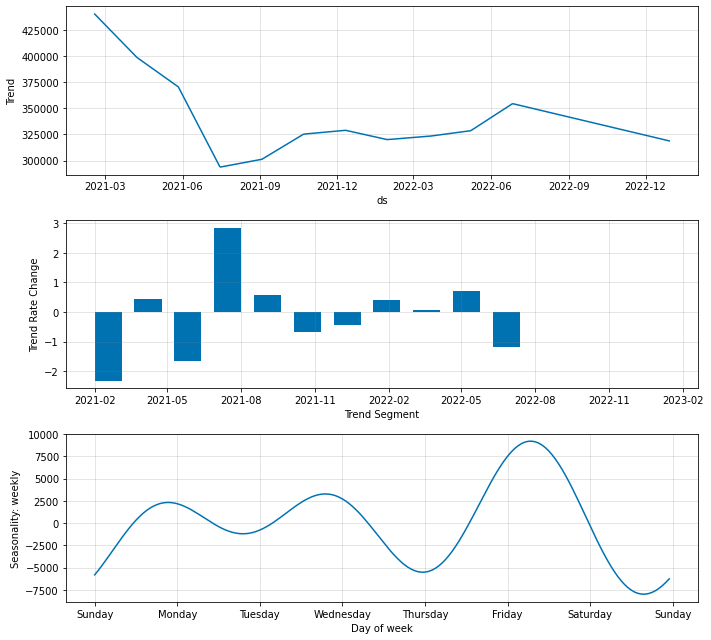

In [85]:
#NeuralProphet
m2, forecast2, forecast_plot2, component_plot2, params_plot2 = fit_neural(df)
metrics_train, metrics_test = eval_neural(df)


In [86]:
print(metrics_train.describe())
print(metrics_test.describe())
plt.show()

                MAE          RMSE         Loss  RegLoss        epoch
count  1.355000e+03  1.355000e+03  1355.000000   1355.0  1355.000000
mean   5.671135e+04  7.388264e+04     0.033608      0.0   136.371218
std    1.162792e+05  1.277289e+05     0.141422      0.0    80.654552
min    2.132868e+04  3.113617e+04     0.002607      0.0     0.000000
25%    2.498435e+04  3.732075e+04     0.003621      0.0    67.000000
50%    2.713116e+04  4.074950e+04     0.004251      0.0   135.000000
75%    3.204284e+04  4.612357e+04     0.005242      0.0   203.000000
max    1.015925e+06  1.076710e+06     1.376736      0.0   314.000000
       Loss_test  RegLoss_test
count   5.000000           5.0
mean    0.002849           0.0
std     0.002453           0.0
min     0.001020           0.0
25%     0.001281           0.0
50%     0.001313           0.0
75%     0.003949           0.0
max     0.006682           0.0


In [110]:
# Comparing Both Models
neural_params =  dict(
    n_forecasts=239,
    n_lags=30,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    batch_size=64,
    epochs=200,
    learning_rate=0.03
)
out = cv_run_both_models(df, neural_params)
print(out)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdi15b27/ls79b7d5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdi15b27/4gtiskek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79971', 'data', 'file=/tmp/tmptdi15b27/ls79b7d5.json', 'init=/tmp/tmptdi15b27/4gtiskek.json', 'output', 'file=/tmp/tmptdi15b27/prophet_modeli283cs9z/prophet_model-20221229150534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:05:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:05:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO - (NP.df_utils._infer_frequency) - M

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.774% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.774% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 239.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.predict) - Raw forecasts are incompatible with plotting utilities
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.628% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.628% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_

Predicting: 3it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


   n_training_days  prophet_RMSE    neural_RMSE  prophet_MAPE  neural_MAPE
0              442  30619.786854  140884.350248      0.546808     0.791972


In [121]:
out

,n_training_days,prophet_RMSE,neural_RMSE,prophet_MAPE,neural_MAPE
0,442,30619.786854,140884.350248,0.546808,0.791972


In [ ]:
#Neural Prophet is better with smaller datasets